This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introducción a Keras y TensorFlow

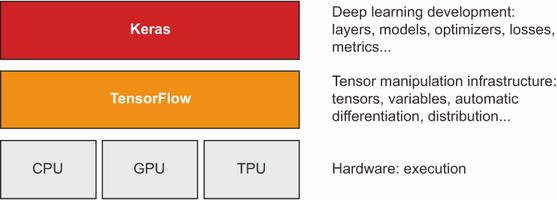

## Primeros pasos con TensorFlow

Entrenar redes neuronales gira en torno a varios conceptos: 

1. La manipulación de tensores, la *infraestructura* que subyace a todo el aprendizaje automático moderno. Esto se traduce en las APIs de TensorFlow:
 * *Tensores*, incluyendo tensores especiales que almacenan el estado de la red (variables)
 * *Operaciones de tensor* como la `suma`, `relu`, `matmul`
 * *Retropropagación (Backpropagation)*, una forma de calcular el gradiente de expresiones matemáticas (usado TensorFlow a través del objeto `GradientTape`)
2. Conceptos de aprendizaje profundo de alto nivel. Esto se traduce en las APIs de Keras:
 * *Capas*, que se combinan en un modelo
 * *Función de pérdida*, que define la señal de retroalimentación utilizada para el aprendizaje
 * *Optimizador*, que determina cómo se realiza el ajuste/aprendizaje a los datos.
 * *Métricas* para evaluar el rendimiento del modelo, como la precisión
 * Un *bucle de entrenamiento* que realiza el descenso de gradiente estocástico en mini lotes

#### Constant tensors and variables

Los tensores son la estructura de datos básica de TensorFlow y Keras. Deben crearse con un contenido y no se les puede asignar un valor. 

Cuando es necesario cambiar el estado de una variable necesitaremos el tipo `tf.Variable`, que deben crearse con un valor inicial también. 

**All-ones o all-zeros tensors**

In [259]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [260]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Tensores aleatorios**

In [261]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[0.53538376]
 [0.8987113 ]
 [0.59465235]], shape=(3, 1), dtype=float32)


In [262]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.22732556]
 [0.10742879]
 [0.40868115]], shape=(3, 1), dtype=float32)


**Los arrays de NumPy son asignables pero los tensores no**

In [263]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [264]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**Crear un TensorFlow variable**

In [265]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.4566794 ],
       [ 1.8290004 ],
       [ 0.91202915]], dtype=float32)>


**Asignar un valor a un TensorFlow variable**

In [266]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Asignar un valor a un subconjunto de un TensorFlow variable**

In [267]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Suma con `assign_add`**

In [268]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Operaciones matemáticas con Tensores

**Operaciones básicas**

In [269]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### GradientTape API

**Cómo usar `GradientTape`**

Basta con abrir un ámbito de `GradientTape`, aplicar algún cálculo a uno o varios tensores de entrada, y recuperar el gradiente del resultado con respecto a las entradas.

In [270]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


**`GradientTape` con tensores constantes como entrada**

Hasta ahora, sólo hemos visto el caso en que los tensores de entrada en `tape.gradient()` eran variables TensorFlow. En realidad es posible que estas entradas sean cualquier tensor arbitrario. Sin embargo, sólo las variables entrenables son *rastreadas* por defecto. Con un tensor constante, hay que marcarlo manualmente como rastreado llamando a `tape.watch()` sobre él. Esto se hace por motivos de eficiencia computacional.

In [271]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


#### Un clasificador lineal completo en TensorFlow

**Generación del conjunto de datos**

In [272]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [273]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [274]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

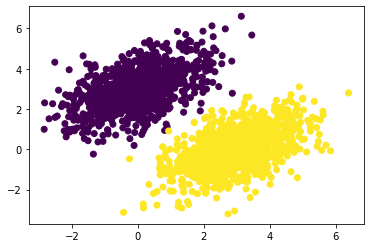

In [275]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creación de la variables del modelo lineal**

Inicializamos `W` con valores aleatorios y `b` a cero.


In [276]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**Propagación hacia delante**

In [277]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**Función de pérdia de error cuadrático medio (MSE)**

* `persample_loss` es un tensor con la misma forma que targets y predictions y almacenará la pérdida correspondiente a cada patrón.
* Devolvemos la contribución media al error del lote. `reduce_mean` por defecto reduce todas las dimensiones a 1, pero podría utilizarse para calcular medias por ejes del tensor. 

In [278]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**El paso de entrenamiento**

Recordad que `GradientTape` nos permite derivar respecto a listas de parámetros. En este caso nos devuelve el gradiente parcial respecto a cada parámetro de la lista. 

In [279]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**Bucle de aprendizaje con el conjunto completo (batch training)**

Para simplificar, haremos un entrenamiento por lotes en lugar de un mini-entrenamiento por lotes: ejecutaremos cada paso de entrenamiento (cálculo del gradiente y actualización de pesos) para todos los datos, en lugar de iterar sobre los datos en pequeños lotes. 

Esto significa que cada paso de entrenamiento tardará mucho más tiempo en ejecutarse pero cada actualización del gradiente será mucho más eficaz para reducir la función de pérdida al incluir todos los datos de entrenamiento. Esto significa que harán falta menos pasos de entrenamiento y que la tasa de aprendizaje debería ser mayor que al utilizar lotes pequeños (`learning_rate = 0.1`). 

❓❓❓ 
* Prueba a utilizar distintas tasas de aprendizaje en este ejemplo y observa el resultado 
* ¿[Tiene sentido que la tasa de aprendizaje sea mayor que 1](https://ai.stackexchange.com/questions/23740/why-is-the-learning-rate-generally-beneath-1)?

* ¿Cómo incluirías un término de regularización en la función de pérdida?

❓❓❓

In [280]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.5674
Loss at step 1: 0.0938
Loss at step 2: 0.0853
Loss at step 3: 0.0796
Loss at step 4: 0.0747
Loss at step 5: 0.0703
Loss at step 6: 0.0663
Loss at step 7: 0.0627
Loss at step 8: 0.0593
Loss at step 9: 0.0563
Loss at step 10: 0.0535
Loss at step 11: 0.0510
Loss at step 12: 0.0487
Loss at step 13: 0.0466
Loss at step 14: 0.0447
Loss at step 15: 0.0430
Loss at step 16: 0.0414
Loss at step 17: 0.0400
Loss at step 18: 0.0387
Loss at step 19: 0.0375
Loss at step 20: 0.0364
Loss at step 21: 0.0354
Loss at step 22: 0.0345
Loss at step 23: 0.0337
Loss at step 24: 0.0330
Loss at step 25: 0.0323
Loss at step 26: 0.0317
Loss at step 27: 0.0311
Loss at step 28: 0.0306
Loss at step 29: 0.0301
Loss at step 30: 0.0297
Loss at step 31: 0.0293
Loss at step 32: 0.0289
Loss at step 33: 0.0286
Loss at step 34: 0.0283
Loss at step 35: 0.0281
Loss at step 36: 0.0278
Loss at step 37: 0.0276
Loss at step 38: 0.0274
Loss at step 39: 0.0272


Como vemos la función de pérdida más o menos se estabiliza.

Ahora vamos a predecir la clase de los patrones. En este ejemplo de clasificación binaria el umbral de decisión entre las clases es `0.5` donde se asigna la clase "1" para los valores mayores que el umbral.

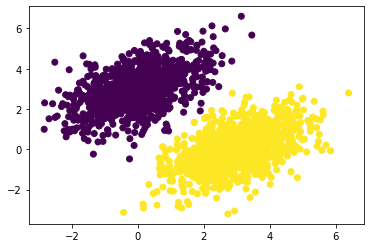

In [281]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Además, podemos dibujar nuestro modelo de decisión, que lo constituye la línea que separa las dos clases, esto es:

```
w1 * x + w2 * y + b = 0.5
y = - w1 / w2 * x + (0.5 - b) / w2
```



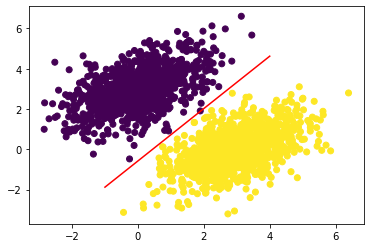

In [282]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomía de una red neuronal para entender conceptos de Keras

### Capas (Layers)

La estructura de datos fundamental en las redes neuronales es la *capa*. Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que da como salida uno o más tensores. Algunas capas no tienen estado, pero lo más frecuente es que las capas tengan un estado: los *pesos* de la capa, uno o varios tensores aprendidos con el descenso por gradiente, que en conjunto almacenan el *conocimiento* de la red.

Según el tipo de dato con el que trabajemos habrá tipos de capas más apropiados para trabajar con estos. 
* Datos vectoriales simples, también llamados tabulares ("hoja de cálculo"), almacenados en tensores de rango 2 `(muestra, características)`, suelen ser procesados por capas densamente conectadas, también llamadas capas totalmente conectadas (la clase `Dense` en Keras). Los datos con disposición temporal o de secuencia, tensores de rango 3 `(muestras, pasos de tiempo, características)`, se procesan normalmente por capas recurrentes, como una capa `LSTM`, o capas de convolución 1D (`Conv1D`). Los datos de imágenes, almacenados en tensores de rango 4, suelen ser procesados por capas de convolución 2D (`Conv2D`).

#### La clase `Layer` en Keras


Casi todo en Keras gira en torno a un objeto de tipo Layer, que encapsula un estado de los pesos y un cálculo sobre la red (*forward pass*). Los pesos se definen en `build()` y el procesamiento en `call()`.


**Una capa `Dense` implementada como subclase de `Layer`**

In [283]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Esta capa que hemos creado se puede instanciar y usarse como una función: 

In [284]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [285]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#### Deducción de la forma de la capa automática: construcción de capas sobre la marcha

En Keras en general sólo necesitaremos especificar la forma de los tensores de salida de la capa, ya que las capas que se añaden al modelo se construyen dinámicamente para adaptar cada capa a la forma de la capa de entrada (la salida de la capa anterior).

La siguiente capa sólo puede conectarse a una capa que espere vectores de 32 dimensiones como entrada.

In [286]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

En Keras, no se implementa la construcción de la capa del todo en el constructor `__build__()` en espera de conocer cuál será la forma de la entrada desde la capa anterior. 

In [287]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

En el ejemplo de red que hicimos desde cero necesitábamos especificar perfectamente las dimensiones de entrada y salida de la secuencia de capas: 

```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```



En Keras basta con lo siguiente:

In [288]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### De las capas a los modelos

Un modelo de aprendizaje profundo consiste en un grafo de capas, clase `Model` en Keras. Hasta ahora sólo hemos visto el modelo `Sequential`, que es una subclase de `Model` pero existen muchas otras topologías de red más avanzadas (Transformers, Residual...)

### El paso "compile" step para configurar el proceso de aprendizaje

Aquí vamos a configurar: 
* Función de pérdida (o función objetivo).
* El optimizador.
* Métricas de evaluación sobre el conjunto de train y opcionalmente validación.

In [289]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [290]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### La importancia de la función de pérdida

### El método fit()

**Calling `fit()` with NumPy data**

In [293]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/10
16/16 [==============================] - 0s 3ms/step - loss: 7.3238 - binary_accuracy: 0.9520
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 7.0601 - binary_accuracy: 0.9515
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 6.8012 - binary_accuracy: 0.9510
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 6.5478 - binary_accuracy: 0.9495
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 6.2993 - binary_accuracy: 0.9480
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 6.0574 - binary_accuracy: 0.9460
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 5.8189 - binary_accuracy: 0.9455
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 5.5863 - binary_accuracy: 0.9435
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 5.3607 - binary_accuracy: 0.9430
Epoch 10/10
16/16 [==============================] - 0s

In [294]:
history.history

{'binary_accuracy': [0.9520000219345093,
  0.9514999985694885,
  0.9509999752044678,
  0.9495000243186951,
  0.9480000138282776,
  0.9459999799728394,
  0.9455000162124634,
  0.9434999823570251,
  0.9430000185966492,
  0.9419999718666077],
 'loss': [7.323776721954346,
  7.0601348876953125,
  6.801158428192139,
  6.547778129577637,
  6.299252033233643,
  6.057425022125244,
  5.818889141082764,
  5.586337566375732,
  5.360720157623291,
  5.140033721923828]}

### Monitorización de la pérdida y las métricas sobre datos de validación

**Parámetro `validation_data`**

❓❓❓

Prueba a añadir más métricas de rendimiento
❓❓❓

In [295]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 4ms/step - loss: 0.2775 - binary_accuracy: 0.9443 - val_loss: 0.0384 - val_binary_accuracy: 0.9917
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0761 - binary_accuracy: 0.9529 - val_loss: 0.0736 - val_binary_accuracy: 0.9650
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0718 - binary_accuracy: 0.9579 - val_loss: 0.0372 - val_binary_accuracy: 0.9983
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0681 - binary_accuracy: 0.9593 - val_loss: 0.0694 - val_binary_accuracy: 0.9733
Epoch 5/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0740 - binary_accuracy: 0.9614 - val_loss: 0.0411 - val_binary_accuracy: 0.9933


### Cómo usar el modelo entrenado

Se puede llamar al modelo como una función, pero esto evaluaría toda la base de datos de test directamente en lugar de por lotes.

```
predictions = model(new_inputs)
```

Habitualmente será más adecuado usar la función `predict`

In [298]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[ 0.9228641 ]
 [ 1.1318518 ]
 [-0.09837416]
 [ 0.02198979]
 [-0.23705968]
 [ 0.8258418 ]
 [ 1.0244929 ]
 [ 1.0419642 ]
 [ 0.45085064]
 [ 0.85634744]]


❓❓❓
Prueba a utilizar el modelo anterior de 4 capas con la base de datos MNIST 
❓❓❓

## Resumen